In [16]:
:dep num = { version = "^0.4.3" }

use num::BigRational as R;
use num::BigInt as I;
use num::BigUint as U;
use num::Integer;
use num::traits::ConstZero;
use num::FromPrimitive;
use num::ToPrimitive;

fn u(i: usize) -> U {
    U::from_usize(i).unwrap()
}

fn rr(i: f64) -> R {
    R::from_float(i).unwrap()
}

fn make_unique<T: Eq + std::hash::Hash>(v: Vec<T>) -> Vec<T> {
    let mut set = std::collections::HashSet::new();
    for x in v {
        set.insert(x);
    }
    set.into_iter().collect()
}

let C = 3;
let g = 3;
let rho_1 = 0.5;
let rho_2 = 1.0;

let mu1 = 10.0;

In [17]:
:dep plotters = { version = "^0.3.6", default-features = false, features = ["evcxr", "all_series", "all_elements"] }
extern crate plotters;
use plotters::prelude::*;

fn draw_chart(data: &Vec<(f32, f32)>, name: impl ToString) -> plotters::evcxr::SVGWrapper {
    let minx = data.iter().min_by(|a, b| a.0.partial_cmp(&b.0).unwrap_or(std::cmp::Ordering::Equal)).unwrap().0;
    let maxx = data.iter().max_by(|a, b| a.0.partial_cmp(&b.0).unwrap_or(std::cmp::Ordering::Equal)).unwrap().0;
    let miny = data.iter().min_by(|a, b| a.1.partial_cmp(&b.1).unwrap_or(std::cmp::Ordering::Equal)).unwrap().1;
    let maxy = data.iter().max_by(|a, b| a.1.partial_cmp(&b.1).unwrap_or(std::cmp::Ordering::Equal)).unwrap().1;
    let figure = evcxr_figure((640, 480), |root| {
        root.fill(&WHITE)?;
        let mut chart = ChartBuilder::on(&root)
            .caption(name.to_string(), ("Arial", 50).into_font())
            .margin(5)
            .x_label_area_size(30)
            .y_label_area_size(30)
            .build_cartesian_2d(minx..maxx, miny..maxy)?;

        chart.configure_mesh().draw()?;

        chart.draw_series(LineSeries::new(
            data.clone(),
            &RED,
        )).unwrap();

        // chart.configure_series_labels()
        //     .background_style(&WHITE.mix(0.8))
        //     .border_style(&BLACK)
        //     .draw()?;
        Ok(())
    });
    return figure;
}

In [18]:
println!("X = (n1, n2): n1 = 0,{g}, n2=0,{C}, n1+n2 <= {C}");
let mut states = vec![];
for n1 in 0..=g {
    for n2 in 0..=C {
        if n1 + n2 <= C {
            states.push((n1, n2));
        }
    }
}
println!("|X| = {}", states.len());

X = (n1, n2): n1 = 0,3, n2=0,3, n1+n2 <= 3
|X| = 10


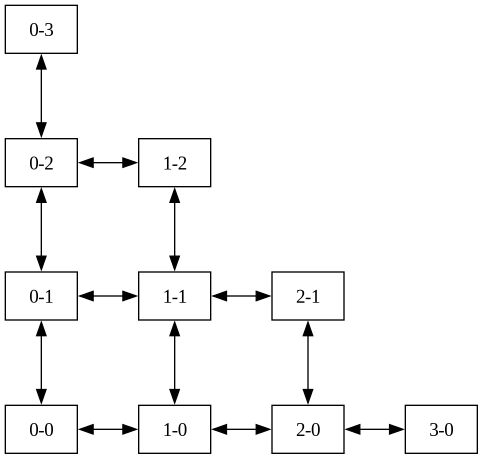

In [19]:
:dep graphviz-rust = { version = "^0.9.0" }
:dep base64 = { version = "^0.22.1" }
use base64::prelude::*;

let mut dot_graph = String::new();

dot_graph.push_str("graph G {\n");
dot_graph.push_str("  rankdir=LR;\n");
dot_graph.push_str("  layout=nop;\n");
dot_graph.push_str("  node [shape=box];\n");

for (n1, n2) in states.iter() {
    dot_graph.push_str(&format!("S{}_{} [label=\"{}-{}\", pos=\"{:.1}, {:.1}\"]\n", n1, n2, n1, n2, n1 * 100, n2 * 100));
    let (n1, n2) = (*n1, *n2);
    if states.contains(&(n1+1, n2)) {
        dot_graph.push_str(&format!("S{}_{} -- S{}_{} [dir=both]\n", n1, n2, n1+1, n2));
    }
    if states.contains(&(n1, n2+1)) {
        dot_graph.push_str(&format!("S{}_{} -- S{}_{} [dir=both]\n", n1, n2, n1, n2+1));
    }
}

dot_graph.push_str("}\n");


let png = graphviz_rust::exec_dot(dot_graph, vec![graphviz_rust::cmd::Format::Png.into()]).unwrap();
let png_base64 = BASE64_STANDARD.encode(&png);
println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", png_base64);

In [20]:
// boundary states
let mut b1 = vec![];
let mut b2 = vec![];
for (n1, n2) in states.iter().cloned() {
    if n1 == g {
        b1.push((n1, n2));
    }
    if n1 + n2 == C {
        b1.push((n1, n2));
    }

    if n1 + n2 == C {
        b2.push((n1, n2));
    }
}
let b1 = make_unique(b1);
let b2 = make_unique(b2);
println!("B1 = (n1, n2) \\in X: n1 = {g} \\lor n1 + n2 = {C} = {b1:?}");
println!("B2 = (n1, n2) \\in X: n1 + n2 = {C} = {b2:?}");

B1 = (n1, n2) \in X: n1 = 3 \lor n1 + n2 = 3 = [(0, 3), (3, 0), (1, 2), (2, 1)]
B2 = (n1, n2) \in X: n1 + n2 = 3 = [(2, 1), (0, 3), (1, 2), (3, 0)]


In [21]:
// interior states
let mut s1 = vec![];
let mut s2 = vec![];
for s in states.iter() {
    if !b1.contains(s) {
        s1.push(*s);
    }
    if !b2.contains(s) {
        s2.push(*s);
    }
}

println!("S1 = (n1, n2) \\in X: n1 < {} \\lor n1+n2 < {} = {s1:?}", g-1, C-1);
println!("S2 = (n1, n2) \\in X: n1+n2 < {} = {s2:?}", C-1);

S1 = (n1, n2) \in X: n1 < 2 \lor n1+n2 < 2 = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0)]
S2 = (n1, n2) \in X: n1+n2 < 2 = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0)]


In [22]:
use std::collections::HashMap;

fn factorial(n: &U) -> R {
    let mut c = n.clone();
    let one = I::from_i8(1).unwrap();
    let mut out = R::new(one.clone(), one.clone());
    while c > U::ZERO {
        out *= R::new(I::from_biguint(num::bigint::Sign::Plus, c.clone()), one.clone());
        c -= 1u32;
    }
    out
}


fn make_probs(log: bool, rho_1: &f64, rho_2: &f64, states: &Vec<(i32, i32)>) -> HashMap<(i32, i32), R> {

    let mut probs = HashMap::new();
    for (n1, n2) in states.iter() {
        let n1 = *n1;
        let n2 = *n2;
        if (n1, n2) != (0, 0) {
            let p = (rr(*rho_1 as f64).pow(n1) / factorial(&u(n1 as usize))) * (rr(*rho_2 as f64).pow(n2) / factorial(&u(n2 as usize)));
            probs.insert((n1, n2), p);
        }
    }
    if log {
        println!("probs: {probs:?}");
    }

    probs.insert((0, 0), R::from_i8(1).unwrap());

    let p00 = probs.iter().map(|(_, v)| v).sum::<R>().pow(-1);

    if log {
        println!("p00 = {} = {}", p00, p00.to_f64().unwrap());
    }

    probs.iter_mut().for_each(|(_, v)| *v *= &p00);

    probs
}

let probs = make_probs(true, &rho_1, &rho_2, &states);
println!("{probs:?}");

probs: {(1, 2): Ratio { numer: 1, denom: 4 }, (2, 1): Ratio { numer: 1, denom: 8 }, (0, 2): Ratio { numer: 1, denom: 2 }, (1, 0): Ratio { numer: 1, denom: 2 }, (0, 1): Ratio { numer: 1, denom: 1 }, (1, 1): Ratio { numer: 1, denom: 2 }, (2, 0): Ratio { numer: 1, denom: 8 }, (0, 3): Ratio { numer: 1, denom: 6 }, (3, 0): Ratio { numer: 1, denom: 48 }}
p00 = 16/67 = 0.23880597014925373
{(1, 2): Ratio { numer: 4, denom: 67 }, (2, 1): Ratio { numer: 2, denom: 67 }, (0, 2): Ratio { numer: 8, denom: 67 }, (1, 0): Ratio { numer: 8, denom: 67 }, (0, 1): Ratio { numer: 16, denom: 67 }, (1, 1): Ratio { numer: 8, denom: 67 }, (2, 0): Ratio { numer: 2, denom: 67 }, (0, 3): Ratio { numer: 8, denom: 201 }, (3, 0): Ratio { numer: 1, denom: 201 }, (0, 0): Ratio { numer: 16, denom: 67 }}


In [23]:
// blocking probability
println!("B_1 = sum(p(n1, n2)), (n1, n2) \\in B1 = {}", b1.iter().map(|loc| probs.get(loc).unwrap()).sum::<R>());
println!("B_2 = sum(p(n1, n2)), (n1, n2) \\in B2 = {}", b2.iter().map(|loc| probs.get(loc).unwrap()).sum::<R>());

B_1 = sum(p(n1, n2)), (n1, n2) \in B1 = 9/67
B_2 = sum(p(n1, n2)), (n1, n2) \in B2 = 9/67


In [24]:
// Average number of serviced requests
fn rrr(n: i64) -> R {
    R::from_i64(n).unwrap()
}
fn avg_serviced_requests(probs: &HashMap<(i32, i32), R>) -> (R, R) {
    let N1 = probs.iter().map(|((n1, n2), p)| rrr(*n1 as i64) * p).sum::<R>();
    let N2 = probs.iter().map(|((n1, n2), p)| rrr(*n2 as i64) * p).sum::<R>();
    (N1, N2)
}

let (N1, N2) = avg_serviced_requests(&probs);
println!("N1 = {} = {}", N1, N1.to_f64().unwrap());
println!("N2 = {} = {}", N2, N2.to_f64().unwrap());

N1 = 29/67 = 0.43283582089552236
N2 = 58/67 = 0.8656716417910447


In [25]:
let N = N1 + N2;
println!("N = {} = {}", N, N.to_f64().unwrap());

N = 87/67 = 1.2985074626865671


In [26]:
// blocking probability depending on intensity
let mut blocking_probs = vec![];
for lambda1 in 0..100 {
    let rho_1 = lambda1 as f64 / &mu1;
    let probs = make_probs(false, &rho_1, &rho_2, &states);
    let blocking_prob = probs.iter().filter(|(v,_)| b1.contains(v)).map(|(_,v)| v).sum::<R>();
    blocking_probs.push((lambda1 as f32, blocking_prob.to_f32().unwrap()));
}
println!("{blocking_probs:?}");
draw_chart(&blocking_probs, "lambda1 vs B_1")

[(0.0, 0.0625), (1.0, 0.07579295), (2.0, 0.08977556), (3.0, 0.10428633), (4.0, 0.11917999), (5.0, 0.13432837), (6.0, 0.1496201), (7.0, 0.16495988), (8.0, 0.18026707), (9.0, 0.19547437), (10.0, 0.21052632), (11.0, 0.22537781), (12.0, 0.23999278), (13.0, 0.25434288), (14.0, 0.26840633), (15.0, 0.28216705), (16.0, 0.29561356), (17.0, 0.3087384), (18.0, 0.32153738), (19.0, 0.33400896), (20.0, 0.34615386), (21.0, 0.35797456), (22.0, 0.369475), (23.0, 0.38066033), (24.0, 0.3915365), (25.0, 0.4021102), (26.0, 0.41238862), (27.0, 0.42237937), (28.0, 0.43209022), (29.0, 0.44152915), (30.0, 0.45070422), (31.0, 0.4596235), (32.0, 0.4682949), (33.0, 0.4767264), (34.0, 0.48492578), (35.0, 0.4929006), (36.0, 0.5006584), (37.0, 0.50820637), (38.0, 0.51555157), (39.0, 0.5227009), (40.0, 0.529661), (41.0, 0.5364383), (42.0, 0.54303896), (43.0, 0.5494691), (44.0, 0.5557344), (45.0, 0.5618404), (46.0, 0.56779265), (47.0, 0.57359624), (48.0, 0.5792561), (49.0, 0.5847772), (50.0, 0.59016395), (51.0, 0.5954

lambda1 vs B_1
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0.1
 
 
 
0.2
 
 
 
0.3
 
 
 
0.4
 
 
 
0.5
 
 
 
0.6
 
 
 
0.7
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,437 47,429 53,421 59,413 65,404 71,395 77,387 83,378 89,370 95,361 101,353 107,345 113,336 119,329 125,321 131,313 137,306 143,299 149,292 156,285 162,278 168,272 174,265 180,259 186,253 192,248 198,242 204,236 210,231 216,226 222,221 228,216 234,211 240,207 246,202 252,198 258,194 264,189 270,185 277,181 283,178 289,174 295,170 301,167 307,163 313,160 319,157 325,154 331,150 337,147 343,144 349,142 355,139 361,136 367,133 373,131 379,128 385,126 391,123 398,121 404,118 410,116 416,114 422,112 428,110 434,107 440,105 446,103 452,101 458,99 464,98 470,96 476,94 482,92 488,90 494,89 500,87 506,85 512,84 519,82 525,80 531,79 537,77 543,76 549,74 555,73 561,72 567,70 573,69 579,68 585,66 591,65 597,64 603,62 609,61 615,60 621,59 627,58 634,56 "/>

In [27]:
// average number of serviced requests depending on intensity
let mut avg_svc = vec![];
for lambda1 in 0..100 {
    let rho_1 = lambda1 as f64 / &mu1;
    let probs = make_probs(false, &rho_1, &rho_2, &states);
    let avg_service = avg_serviced_requests(&probs).0;
    avg_svc.push((lambda1 as f32, avg_service.to_f32().unwrap()));
}
println!("{avg_svc:?}");
draw_chart(&avg_svc, "lambda1 vs Nbar_1")

[(0.0, 0.0), (1.0, 0.092420705), (2.0, 0.1820449), (3.0, 0.2687141), (4.0, 0.352328), (5.0, 0.43283582), (6.0, 0.5102279), (7.0, 0.5845281), (8.0, 0.65578634), (9.0, 0.72407305), (10.0, 0.7894737), (11.0, 0.8520844), (12.0, 0.91200864), (13.0, 0.9693543), (14.0, 1.0242311), (15.0, 1.0767494), (16.0, 1.1270183), (17.0, 1.1751447), (18.0, 1.2212328), (19.0, 1.265383), (20.0, 1.3076923), (21.0, 1.3482535), (22.0, 1.3871549), (23.0, 1.4244813), (24.0, 1.4603124), (25.0, 1.4947245), (26.0, 1.5277896), (27.0, 1.5595757), (28.0, 1.5901474), (29.0, 1.6195655), (30.0, 1.6478873), (31.0, 1.6751672), (32.0, 1.7014563), (33.0, 1.7268028), (34.0, 1.7512524), (35.0, 1.7748479), (36.0, 1.7976298), (37.0, 1.8196365), (38.0, 1.840904), (39.0, 1.8614664), (40.0, 1.8813559), (41.0, 1.9006029), (42.0, 1.9192362), (43.0, 1.9372829), (44.0, 1.9547688), (45.0, 1.9717181), (46.0, 1.9881537), (47.0, 2.0040977), (48.0, 2.0195706), (49.0, 2.034592), (50.0, 2.0491803), (51.0, 2.0633533), (52.0, 2.0771277), (53.0,

lambda1 vs Nbar_1
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
0.0
 
 
 
0.5
 
 
 
1.0
 
 
 
1.5
 
 
 
2.0
 
 
 
 
0.0
 
 
 
10.0
 
 
 
20.0
 
 
 
30.0
 
 
 
40.0
 
 
 
50.0
 
 
 
60.0
 
 
 
70.0
 
 
 
80.0
 
 
 
90.0
 
 
<polyline fill="none" opacity="1" stroke="#FF0000" stroke-width="1" points="35,444 41,430 47,416 53,402 59,389 65,376 71,364 77,352 83,341 89,330 95,320 101,310 107,301 113,292 119,283 125,275 131,267 137,259 143,252 149,245 156,238 162,232 168,226 174,220 180,214 186,209 192,203 198,198 204,194 210,189 216,184 222,180 228,176 234,172 240,168 246,164 252,161 258,157 264,154 270,151 277,148 283,145 289,142 295,139 301,136 307,133 313,131 319,128 325,126 331,123 337,121 343,119 349,117 355,115 361,113 367,111 373,109 379,107 385,105 391,103 398,101 404,100 410,98 416,96 422,95 428,93 434,92 440,90 446,89 452,87 458,86 464,85 470,83 476,82 482,81 488,80 494,78 500,77 506,76 512,75 519,74 525,73 531,72 537,71 543,70 549,69 555,68 561,67 567,66 573,65 579,64 585,63 591,62 597,61 603,60 609,60 615,59 621,58 627,57 634,56 "/>